In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
from tqdm import tqdm

In [2]:
rootfolder = '../'

Load the image and rescale it in $[0,1]$

In [3]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = img[50:200, 50:200]
imsz = img.shape

# patch size
p = 5
h=p//2

# number of elements in the patch
M = p ** 2

# radius of the search neighborhood
H = 12


Corrupt the image with white gaussian noise

In [4]:
sigma_noise = 20/255
noisy_img = img + sigma_noise * np.random.randn(*img.shape)

Compute the psnr of the noisy input

In [5]:
def psnr(oimg,nimg):
    return 10*np.log10(1/np.mean((oimg-nimg)**2))

In [6]:
psnr_noisy = psnr(img, noisy_img)


Text(0.5, 1.0, 'Noisy image, PSNR = 22.06')

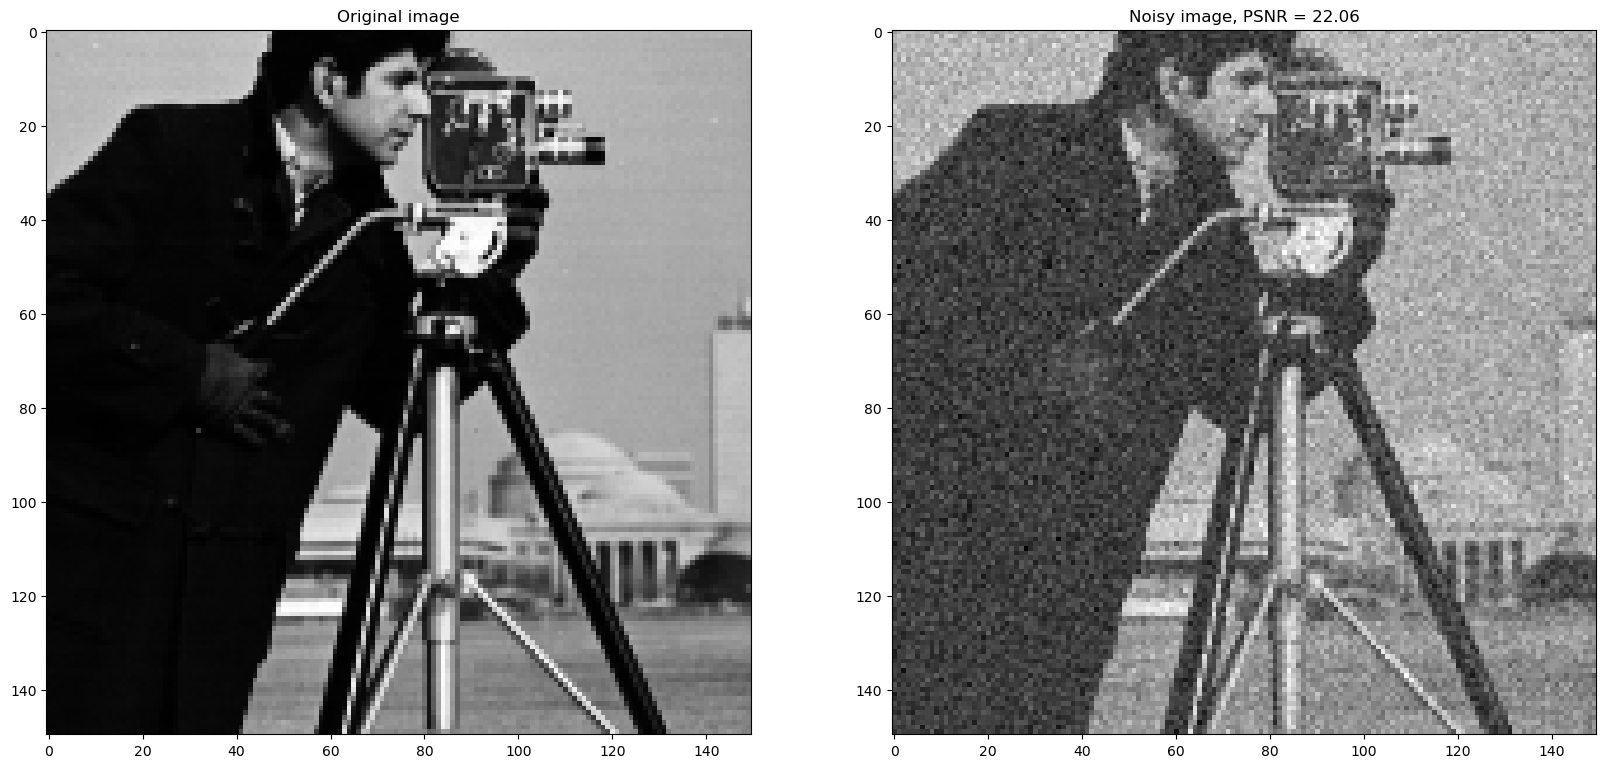

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Pixel-based NL-Means
--------------------
Set parameters and initialize the variables

In [8]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# pad the noisy image
img_pad = np.pad(noisy_img, h, mode='symmetric')

Main loop

In [10]:
for r in range(0, imsz[0]):
    for c in range(0, imsz[1]):
        # extrach the patch from img_pad whose center has the location (i, j) in the noisy image
        s = img_pad[r:r+2*h, c:c+2*h]

        # initialize the pixel estimate and the total weights
        pixel_hat = 0
        weight = 0
        for i in range(-H, H+1):
            for j in range(-H, H+1):
                
                r_prime = i + r + h
                c_prime = j + c + h
                if r_prime >= h and r_prime-h <= imsz[0] and c_prime > h and c_prime-h < imsz[1]:
                    
                    # extract the patch
                    z = img_pad[r_prime-h:r_prime+h,c_prime-h:c_prime+h]

                    # compute the distance with the reference patch
                    d = np.linalg.norm(s - z, 2)**2

                    # update the weight and the pixel estimate
                    w = np.exp(-d / (M * sigma_noise**2))
                    pixel_hat += w * z[h, h]
                    weight += w

        # estimate the pixel (i, j) as the weighted average of the central pixel of the extracted patches
        img_hat[r, c] = pixel_hat / weight

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 27.29')

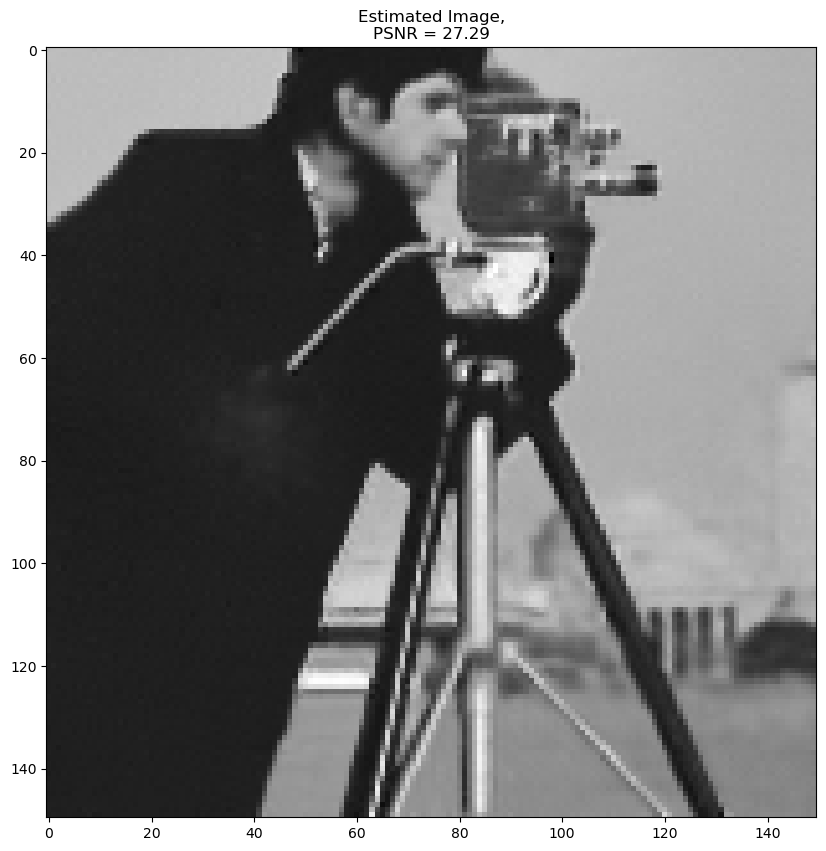

In [11]:
psnr_hat = psnr(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
